# LE PRETRAITEMENT EN NLP

## A-préparation de données

importer dataset

In [1]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from tokenizers import ByteLevelBPETokenizer
from nltk.tokenize import word_tokenize
from transformers import AutoTokenizer
from googletrans import Translator
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from langdetect import detect
from textblob import TextBlob
from pywaffle import Waffle
import pandas as pd
import string
import spacy
import nltk
import re
import os

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading punkt_tab: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading vader_lexicon: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


False

In [3]:
nltk.data.path.append('/home/mina/nltk_data')
nltk.download('punkt', download_dir='/home/mina/nltk_data')

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


False

In [5]:
df = pd.read_csv('./spooky.csv')

afficher les 10 premiers échantillons 

In [6]:
df.head(10)

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL
5,id22965,"A youth passed in solitude, my best years spen...",MWS
6,id09674,"The astronomer, perhaps, at this point, took r...",EAP
7,id13515,The surcingle hung in ribands from my body.,EAP
8,id19322,I knew that you could not say to yourself 'ste...,EAP
9,id00912,I confess that neither the structure of langua...,MWS


In [7]:
df.shape

(19579, 3)

In [8]:
df.isnull().sum()

id        0
text      0
author    0
dtype: int64

In [9]:
df.duplicated().sum()

0

## B-nettoyage d’un texte

gérer les caractères répétitifs (par exemple « cooooool » → « cool »)

In [10]:
df['text']

0        This process, however, afforded me no means of...
1        It never once occurred to me that the fumbling...
2        In his left hand was a gold snuff box, from wh...
3        How lovely is spring As we looked from Windsor...
4        Finding nothing else, not even gold, the Super...
                               ...                        
19574    I could have fancied, while I looked at it, th...
19575    The lids clenched themselves together as if in...
19576    Mais il faut agir that is to say, a Frenchman ...
19577    For an item of news like this, it strikes us i...
19578    He laid a gnarled claw on my shoulder, and it ...
Name: text, Length: 19579, dtype: object

In [11]:
def remove_repeated_chars(text):
    return re.sub(r'(.)\1+', r'\1\1', text)

In [12]:
remove_repeated_chars('cooooool')

'cool'

In [13]:
df['text'] = df['text'].apply(remove_repeated_chars)

manipuler des homoglyphes (par exemple « $tupide » → « stupide »)

In [14]:
def replace_homoglyphs(text):
    homoglyphs = {'$': 's', '@': 'a', '0': 'o', '3': 'e'}
    for char, replacement in homoglyphs.items():
        text = text.replace(char, replacement)
    return text

In [15]:
replace_homoglyphs('$uper')

'super'

In [16]:
df['text'] = df['text'].apply(replace_homoglyphs)

transformer les entrées spéciales telles que les URL, les adresses e-mail et les balises HTML à une forme canonique

In [17]:
def clean_special_entries(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '[URL]', text, flags=re.MULTILINE)
    text = re.sub(r'\S+@\S+', '[EMAIL]', text)
    text = BeautifulSoup(text, 'html.parser').get_text()
    return text

In [18]:
clean_special_entries('https://www.google.com is site of goole, email me at a.ghandouz@esi-sba.dz')

'[URL] is site of goole, email me at [EMAIL]'

In [19]:
clean_special_entries('<html><head></head><body><header>hey there</header></body></html>')

'hey there'

In [20]:
df['text'] = df['text'].apply(clean_special_entries)

mettre tous les caracteres en minuscule

In [21]:
def text_to_lower(text):
    return text.lower()

In [22]:
text_to_lower("HeyY thERe")

'heyy there'

In [23]:
df['text'] = df['text'].str.lower()

supprimer les ponctuation

In [24]:
def remove_punc(text):
    return text.translate(str.maketrans('', '', string.punctuation))

In [25]:
remove_punc("hey! bye.")

'hey bye'

In [26]:
df['text'] = df['text'].apply(remove_punc)

supprimer les mots-vide

In [27]:
stop_words = set(stopwords.words('english'))
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

detecter la langues et traduire

In [28]:
translator = Translator()

def detect_and_translate(text):
    try:
        lang = detect(text)
        if lang != 'en':
            text = translator.translate(text, dest='en').text
    except:
        pass
    return text

In [29]:
detect_and_translate('مرحبا')

'مرحبا'

In [ ]:
df['text'] = df['text'].apply(detect_and_translate)

supprimer les repetition

In [30]:
def remove_repeated_words(text):
    words = text.split()
    cleaned_words = [words[i] for i in range(len(words)) if i == 0 or words[i] != words[i-1]]
    return ' '.join(cleaned_words)

In [31]:
remove_repeated_words('hello hello world')

'hello world'

In [32]:
df['text'] = df['text'].apply(remove_repeated_words).str.strip()

## C-segmentation

segmenter chaque phrase sur les espaces/ponctuation

In [33]:
df['tokens_space'] = df['text'].apply(lambda x: x.split())

In [34]:
df['tokens_space'].head()

0    [process, however, afforded, means, ascertaini...
1    [never, occurred, fumbling, might, mere, mistake]
2    [left, hand, gold, snuff, box, capered, hill, ...
3    [lovely, spring, looked, windsor, terrace, six...
4    [finding, nothing, else, even, gold, superinte...
Name: tokens_space, dtype: object

In [35]:
'heyy there; Bye!'.split()

['heyy', 'there;', 'Bye!']

segmenter chaque phrase avec un algo de segmentation base sur des regles

In [36]:
word_tokenize("heyy there, it's a good day, isn't it!!")

['heyy',
 'there',
 ',',
 'it',
 "'s",
 'a',
 'good',
 'day',
 ',',
 'is',
 "n't",
 'it',
 '!',
 '!']

In [37]:
df['tokens_rule'] = df['text'].apply(word_tokenize)

segmenter chaque phrase avec un algo de segmentation en sous mots (subword tkenization)

In [38]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [39]:
tokens = tokenizer.tokenize("Subword tokenization is a powerful technique for NLP tasks.")

In [40]:
tokens

['sub',
 '##word',
 'token',
 '##ization',
 'is',
 'a',
 'powerful',
 'technique',
 'for',
 'nl',
 '##p',
 'tasks',
 '.']

In [41]:
df['tokens_subword'] = df['text'].apply(tokenizer.tokenize)

In [42]:
df['tokens_subword'].head()

0    [process, however, afforded, means, as, ##cer,...
1    [never, occurred, fu, ##mbling, might, mere, m...
2    [left, hand, gold, s, ##nu, ##ff, box, cape, #...
3    [lovely, spring, looked, windsor, terrace, six...
4    [finding, nothing, else, even, gold, superinte...
Name: tokens_subword, dtype: object

## D-reconnaissance d'entite nommee

reconnatre les entites nommees avec spaCy

In [43]:
nlp = spacy.load('en_core_web_sm')
df['entities'] = df['text'].apply(lambda x: [(ent.text, ent.label_) for ent in nlp(x).ents])

In [44]:
df['entities'].head()

0                                                   []
1                                                   []
2    [(gold snuff, ORG), (hill cutting manner fanta...
3                 [(sixteen, CARDINAL), (years, DATE)]
4                                                   []
Name: entities, dtype: object

analyse des POS tages

In [45]:
df['pos_tags'] = df['text'].apply(lambda x: [(token.text, token.pos_) for token in nlp(x)])

In [46]:
df['pos_tags'].head()

0    [(process, NOUN), (however, ADV), (afforded, V...
1    [(never, ADV), (occurred, VERB), (fumbling, VE...
2    [(left, VERB), (hand, NOUN), (gold, PROPN), (s...
3    [(lovely, ADJ), (spring, NOUN), (looked, VERB)...
4    [(finding, VERB), (nothing, PRON), (else, ADV)...
Name: pos_tags, dtype: object

## E-reduction des formes

lemmatisation et racinisation avec nltk

In [47]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

df['lemmatized'] = df['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
df['stemmed'] = df['text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

In [48]:
df['lemmatized'].head()                    

0    process however afforded mean ascertaining dim...
1           never occurred fumbling might mere mistake
2    left hand gold snuff box capered hill cutting ...
3    lovely spring looked windsor terrace sixteen f...
4    finding nothing else even gold superintendent ...
Name: lemmatized, dtype: object

In [49]:
df['stemmed'].head()

0    process howev afford mean ascertain dimens dun...
1                  never occur fumbl might mere mistak
2    left hand gold snuff box caper hill cut manner...
3    love spring look windsor terrac sixteen fertil...
4    find noth els even gold superintend abandon at...
Name: stemmed, dtype: object

## F-analyse des frequences

comptes les occurrences de great par auteur

In [50]:
df['great_count'] = df['text'].apply(lambda x: x.count('great'))
great_by_author = df.groupby('author')['great_count'].sum()

In [51]:
great_by_author

author
EAP    307
HPL    244
MWS    163
Name: great_count, dtype: int64

visualize great avec pywaffle

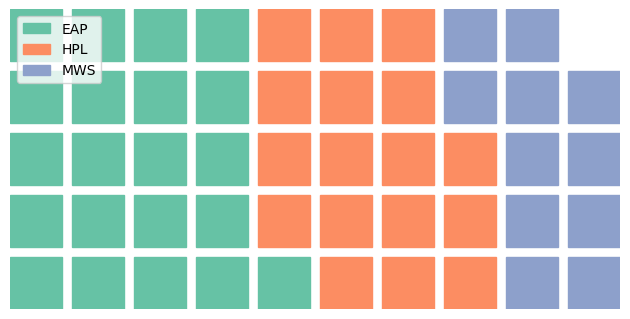

In [52]:
plt.figure(FigureClass=Waffle, rows=5, columns=10, values=great_by_author.to_dict(), legend={'loc': 'upper left'})
plt.show()

comptes les occurrences de impossible par auteur

In [53]:
df['impossible_count'] = df['text'].apply(lambda x: x.count('impossible'))
impossible_by_author = df.groupby('author')['impossible_count'].sum()

In [54]:
impossible_by_author

author
EAP    64
HPL    16
MWS    19
Name: impossible_count, dtype: int64

visualize impossible avec pywaffle

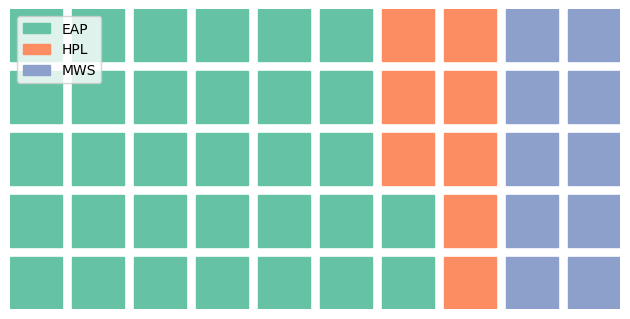

In [55]:
plt.figure(FigureClass=Waffle, rows=5, columns=10, values=impossible_by_author.to_dict(), legend={'loc': 'upper left'})
plt.show()

utiliser wordclound pour chaque auteur

In [56]:
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

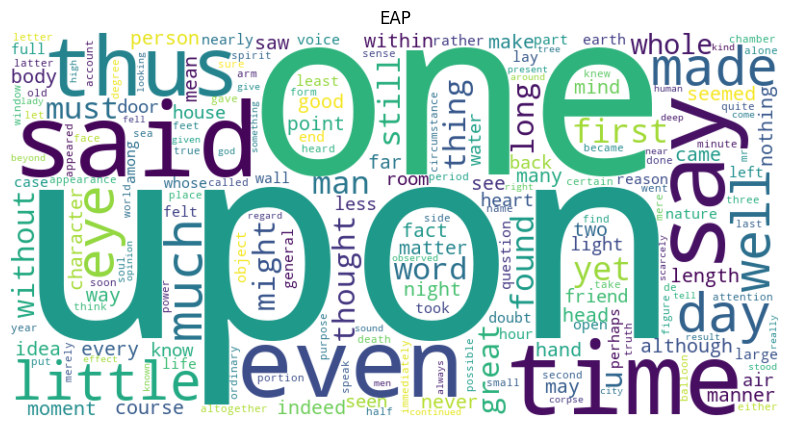

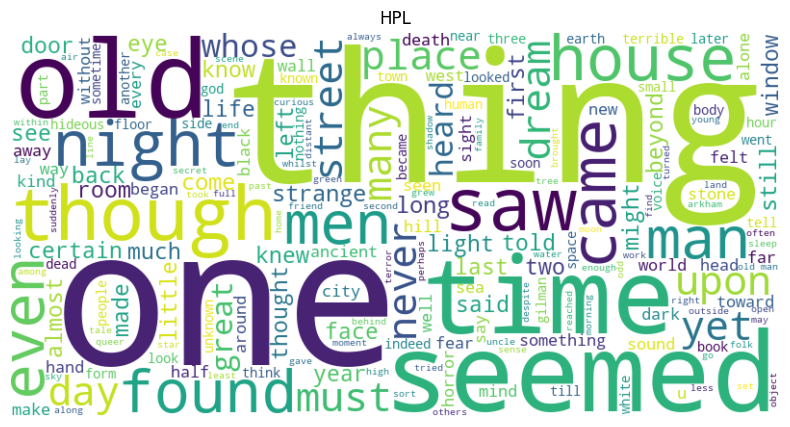

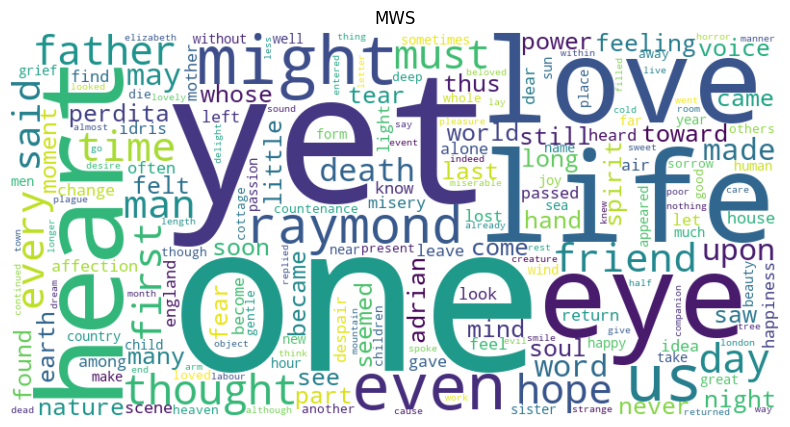

In [57]:
for author in df['author'].unique():
    text = ' '.join(df[df['author'] == author]['text'])
    generate_wordcloud(text, author)

les 100 meilleurs mots positifs/negatifs

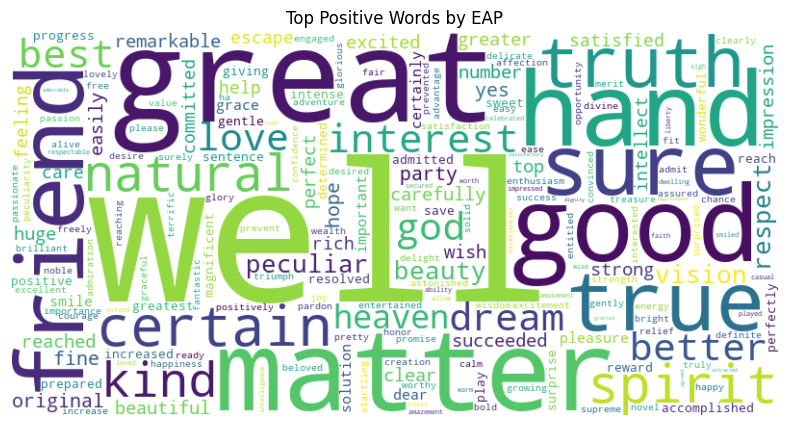

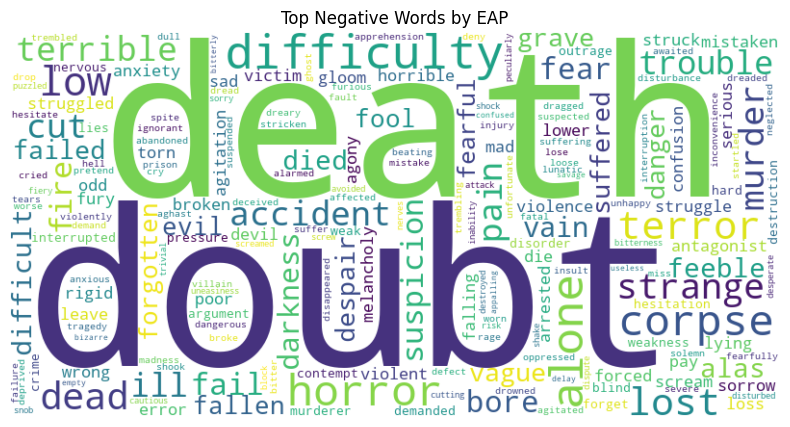

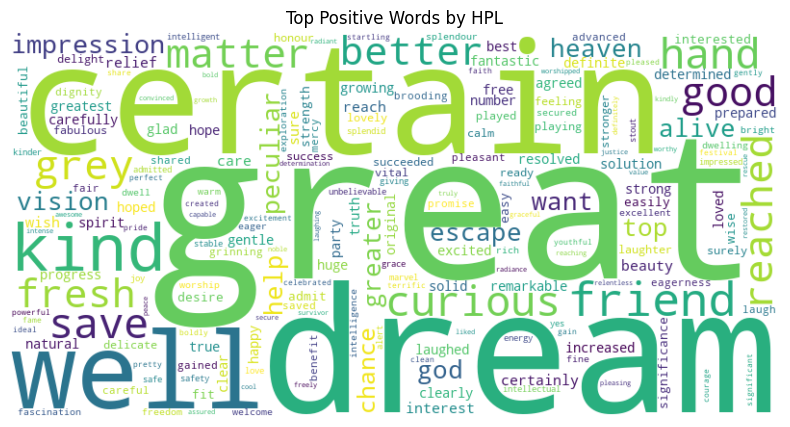

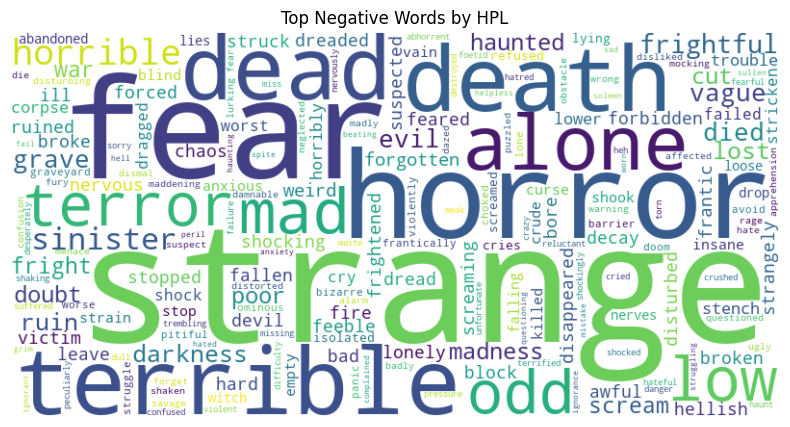

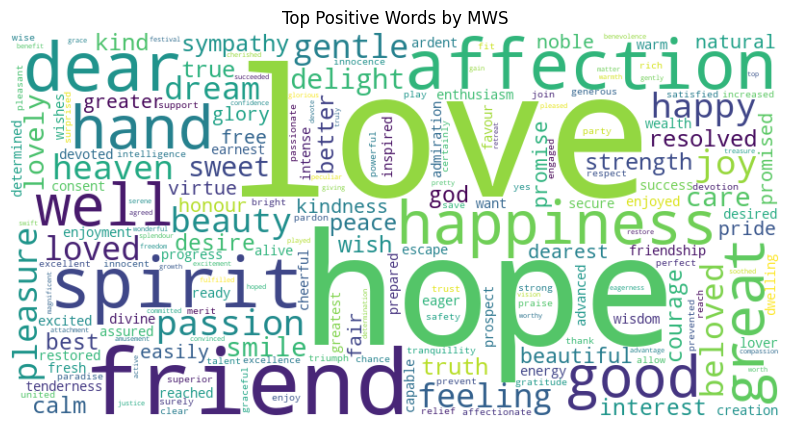

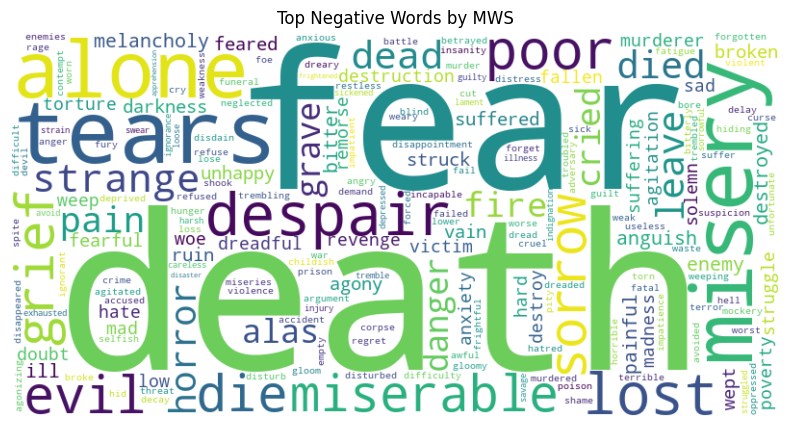

In [58]:
sia = SentimentIntensityAnalyzer()

def classify_words(text):
    words = text.split()
    positive_words = [word for word in words if sia.polarity_scores(word)['compound'] > 0]
    negative_words = [word for word in words if sia.polarity_scores(word)['compound'] < 0]
    return " ".join(positive_words), " ".join(negative_words)

for author in df['author'].unique():
    text = " ".join(df[df['author'] == author]['text'])
    positive_text, negative_text = classify_words(text)
    generate_wordcloud(positive_text, f"Top Positive Words by {author}")
    generate_wordcloud(negative_text, f"Top Negative Words by {author}")

analyse de sentiment

In [59]:
df['sentiment'] = df['text'].apply(lambda x: sia.polarity_scores(x)['compound'])
sentiment_counts = df.groupby('author')['sentiment'].mean()

In [60]:
df['sentiment'].head()

0   -0.5216
1   -0.3400
2    0.9246
3    0.9460
4   -0.8078
Name: sentiment, dtype: float64

In [61]:
sentiment_counts

author
EAP    0.064094
HPL   -0.047132
MWS    0.071605
Name: sentiment, dtype: float64

In [62]:
df.head()

,id,text,author,tokens_space,tokens_rule,tokens_subword,entities,pos_tags,lemmatized,stemmed,great_count,impossible_count,sentiment
0,id26305,process however afforded means ascertaining di...,EAP,"[process, however, afforded, means, ascertaini...","[process, however, afforded, means, ascertaini...","[process, however, afforded, means, as, ##cer,...",[],"[(process, NOUN), (however, ADV), (afforded, V...",process however afforded mean ascertaining dim...,process howev afford mean ascertain dimens dun...,0,0,-0.5216
1,id17569,never occurred fumbling might mere mistake,HPL,"[never, occurred, fumbling, might, mere, mistake]","[never, occurred, fumbling, might, mere, mistake]","[never, occurred, fu, ##mbling, might, mere, m...",[],"[(never, ADV), (occurred, VERB), (fumbling, VE...",never occurred fumbling might mere mistake,never occur fumbl might mere mistak,0,0,-0.3400
2,id11008,left hand gold snuff box capered hill cutting ...,EAP,"[left, hand, gold, snuff, box, capered, hill, ...","[left, hand, gold, snuff, box, capered, hill, ...","[left, hand, gold, s, ##nu, ##ff, box, cape, #...","[(gold snuff, ORG), (hill cutting manner fanta...","[(left, VERB), (hand, NOUN), (gold, PROPN), (s...",left hand gold snuff box capered hill cutting ...,left hand gold snuff box caper hill cut manner...,1,0,0.9246
3,id27763,lovely spring looked windsor terrace sixteen f...,MWS,"[lovely, spring, looked, windsor, terrace, six...","[lovely, spring, looked, windsor, terrace, six...","[lovely, spring, looked, windsor, terrace, six...","[(sixteen, CARDINAL), (years, DATE)]","[(lovely, ADJ), (spring, NOUN), (looked, VERB)...",lovely spring looked windsor terrace sixteen f...,love spring look windsor terrac sixteen fertil...,0,0,0.9460
4,id12958,finding nothing else even gold superintendent ...,HPL,"[finding, nothing, else, even, gold, superinte...","[finding, nothing, else, even, gold, superinte...","[finding, nothing, else, even, gold, superinte...",[],"[(finding, VERB), (nothing, PRON), (else, ADV)...",finding nothing else even gold superintendent ...,find noth els even gold superintend abandon at...,0,0,-0.8078


In [65]:
df.to_csv('spooky_new.csv', index=False)